<a href="https://colab.research.google.com/github/Plashka320/Stat_prack_HW_VyuzhaninPD_2025/blob/main/hw_3_random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Serial test

Idea: break the sequence $x_1, x_2, x_3, ..., x_{2n}$ into consecutive series of length $2$: $(x_1, x_2), (x_3, x_4), ..., (x_{2n-1}, x_{2n})$ and look at each element as a random and independent point in $2D$ space. Next, apply chi-square. Similarly, one can construct series of length $3, 4$, etc.

### Problem 1
Implement serial test and apply to a `samples`

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare

def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 1
samples = [rng() for _ in range(1000)]

def serial_test(samples, k=10, d=2):
    """
    k: number of bins per dimension (grid size)
    d: dimension (e.g., 2 for pairs, 3 for triplets)
    """
    samples = np.array(samples)
    n = len(samples) // d
    points = samples[:n * d].reshape(n, d)
    bins = np.linspace(0, 1, k + 1)
    hist, _ = np.histogramdd(points, bins=[bins] * d)
    f_obs = hist.flatten()
    expected_count = n / (k ** d)
    f_exp = np.full(f_obs.shape, expected_count)

    chi2_stat, p_value = chisquare(f_obs, f_exp)
    return chi2_stat, p_value, f_obs, f_exp

chi2_stat, p_value, f_obs, f_exp = serial_test(samples, k=10, d=2)

print(f"Chi-square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")

plt.figure(figsize=(8, 6))
plt.bar(range(len(f_obs)), f_obs, alpha=0.7, label="Observed")
plt.plot(range(len(f_exp)), f_exp, "r--", label="Expected")
plt.xlabel("Grid Cell Index")
plt.ylabel("Frequency")
plt.title("Serial Test: Observed vs Expected Frequencies")
plt.legend()
plt.show()


### Permutation test

We again decompose the sequence $x_1, x_2, x_3, ..., x_{dn}$ into consecutive series of length $d$: $(x_1, ..., x_d), (x_{d+1}, x_{2d+d}), \ldots, (x_{nd-d+1}, x_{nd})$. A series of $d$ elements can be ordered in $d!$ ways and each way of ordering is equally probable. Hence the idea of the test is to count how many times each ordering occurs among $n$ series and apply the $\chi^2$ test.

### Problem 2*
Implement permutation test and apply to a `samples`

In [ ]:
# Your code here

### Problem 3

Provide a statistical test to show that `rng_bad` has problems but `rng_good` does not.

In [ ]:
from scipy import stats
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def rng_bad():
    m, a, c = 2**31, 65539, 0
    rng_bad.current = (a * rng_bad.current + c) % m
    return rng_bad.current / m
rng_bad.current = 1

# в основе ЛКГ.  период: 2^128 чисел, равномернее заполняет многомерное пространство
rng_good = np.random.Generator(np.random.PCG64())
# проверяет распределение минимальных расстояний между случайными точками в 3D пространстве
def random_spheres_test(generator, n=10000):
    samples = np.array([generator() for _ in range(n*3)]).reshape(n, 3)
    min_volumes = []

    for i in tqdm(range(0, n, 10)):  # Проверяем каждую 10-ю точку
        dists = np.sqrt(np.sum((samples - samples[i])**2, axis=1))
        dists[dists == 0] = np.inf
        min_volumes.append(4/3 * np.pi * np.min(dists)**3)
        #cравниваем распределение объемов с экспоненциальным(хороший генератор даст экспоненциальное распределение объемов)
    return stats.kstest(min_volumes, 'expon', args=(0, np.mean(min_volumes)))

def enhanced_3d_test(generator, num_samples=10000):
  #Генерация 3D точек
    samples = np.array([generator() for _ in range(num_samples*3)]).reshape(num_samples, 3)

    fig = go.Figure(data=[go.Scatter3d(
        x=samples[:,0], y=samples[:,1], z=samples[:,2],
        mode='markers',
        marker=dict(size=2, opacity=0.5),
        name='3D распределение'
    )])

    fig.update_layout(
        title='3D тест распределения',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        width=800,
        height=600
    )
    fig.show()
    '''
    Хи-квадрат тест:
    Делим куб [0,1)^3 на k^3 маленьких кубиков
    Считаем сколько точек попало в каждый
    Сравниваем с ожидаемым равномерным распределением
'''

    k = 20  # количество бинов по каждой оси
    hist, _ = np.histogramdd(samples, bins=k)
    expected = num_samples / k**3
    chi2_stat = np.sum((hist.flatten() - expected)**2 / expected)
    p_value = 1 - stats.chi2.cdf(chi2_stat, k**3 - 1)

    return p_value

print("=== Тестирование плохого генератора ===")
print("Тест минимальных сфер p-value:", random_spheres_test(rng_bad).pvalue)
print("3D серийный тест p-value:", enhanced_3d_test(rng_bad))

print("\n=== Тестирование хорошего генератора ===")
print("Тест минимальных сфер p-value:", random_spheres_test(rng_good.random).pvalue)
print("3D серийный тест p-value:", enhanced_3d_test(rng_good.random))

print("\n=== Тестирование numpy.random.uniform ===")
print("Тест минимальных сфер p-value:", random_spheres_test(np.random.uniform).pvalue)
print("3D серийный тест p-value:", enhanced_3d_test(np.random.uniform))

=== Тестирование плохого генератора ===


100%|██████████| 1000/1000 [00:00<00:00, 1113.98it/s]


Тест минимальных сфер p-value: 1.8993054481641092e-32


3D серийный тест p-value: 0.0

=== Тестирование хорошего генератора ===


100%|██████████| 1000/1000 [00:00<00:00, 1179.53it/s]


Тест минимальных сфер p-value: 0.910441646007864


3D серийный тест p-value: 0.02256727931343483

=== Тестирование numpy.random.uniform ===


100%|██████████| 1000/1000 [00:00<00:00, 1207.37it/s]


Тест минимальных сфер p-value: 0.7239593591434084


3D серийный тест p-value: 0.7243848624017446


* More randomness tests - [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests).
* More methods for generating a uniform value [here](https://en.wikipedia.org/wiki/List_of_random_number_generators).
* A story about dynamical systems and the transition to chaos https://www.youtube.com/watch?v=ovJcsL7vyrk&feature=youtu.be

# Generating a sample from a given distribution

Suppose we have a random number generator from the segment [0, 1] (use the `np.random.rand()` function for this). How to get a sample from another distribution $F$?

### Problem 4
Simulate a sample of 1000 from a discrete distribution on a set of digits $0, 1, 2, \ldots, 9$ with weights $0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2$. Construct a histogram from the sample. Optimise the algorithm by ordering the weights.

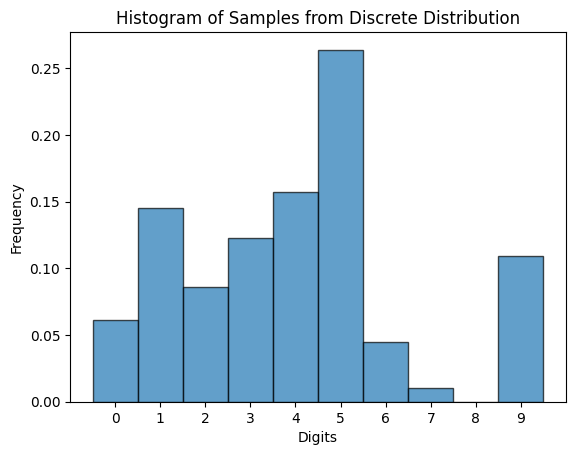

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

weights = np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])

normalized_weights = weights / np.sum(weights)

sorted_indices = np.argsort(normalized_weights)[::-1]
sorted_weights = normalized_weights[sorted_indices]

cdf = np.cumsum(sorted_weights)

random_samples = []
for _ in range(1000):
    rand = np.random.random()
    digit = np.searchsorted(cdf, rand)
    random_samples.append(sorted_indices[digit])

plt.hist(random_samples, bins=np.arange(11) - 0.5, density=True, edgecolor='black', alpha=0.7)
plt.xlabel('Digits')
plt.ylabel('Frequency')
plt.title('Histogram of Samples from Discrete Distribution')
plt.xticks(np.arange(10))
plt.show()


## Inverse transform method

The following proposition is the idea behind the *inverse transform* method:

If $\xi$ has a uniform distribution in $[0,1]$, then $F^{-1}(\xi)$ is distributed according to the law of $F$. (For which $F$ is this true?)

### Problem 5
Simulate a sample of size 1000 from the distribution $\operatorname{Exp}(\lambda)$ using the Inverse transform method. Construct a sample histogram and an accurate plot of the distribution density.

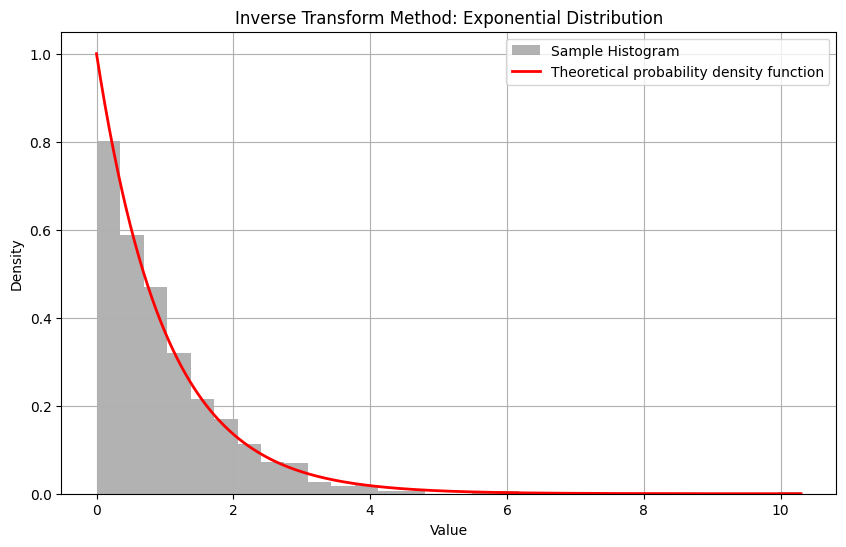

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

lambda_param = 1.0

uniform_samples = np.random.uniform(0, 1, 1000)

exponential_samples = -np.log(uniform_samples) / lambda_param

plt.figure(figsize=(10, 6))
plt.hist(exponential_samples, bins=30, density=True, alpha=0.6, color='gray', label="Sample Histogram")

x = np.linspace(0, np.max(exponential_samples), 1000)
pdf = lambda_param * np.exp(-lambda_param * x)
plt.plot(x, pdf, 'r-', lw=2, label="Theoretical probability density function")

plt.title("Inverse Transform Method: Exponential Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


### Problem 6
Justify (orally) that the accept-reject method really samples from the required distribution. Simulate $1000$ points from the distribution with density $e^xcos^2x \cdot \mathbb{I}_{[-\frac\pi2, \frac\pi2]}$. Plot the sampled histogram on the sample and compare it with the plot of the exact density function.

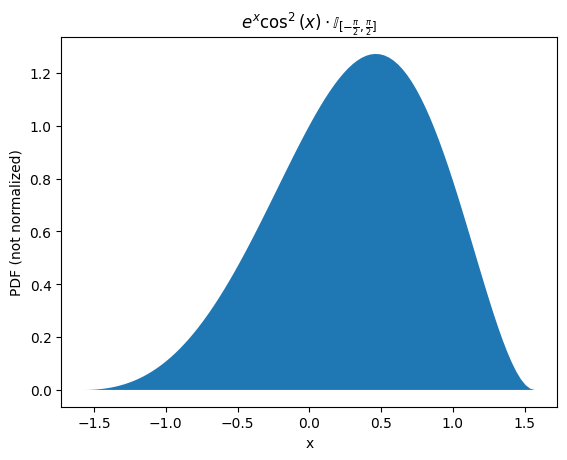

In [ ]:
fig = plt.figure()

x = np.linspace(-np.pi/2, np.pi/2, 100)
density = np.exp(x) * np.cos(x) ** 2 # not normalized density!
plt.fill_between(x, 0, density)
plt.ylabel('PDF (not normalized)')
plt.xlabel('x')
plt.title(r'$e^x \cos^2(x) \cdot \mathbb{I}_{[-\frac{\pi}{2}, \frac{\pi}{2}]}$')

plt.show()

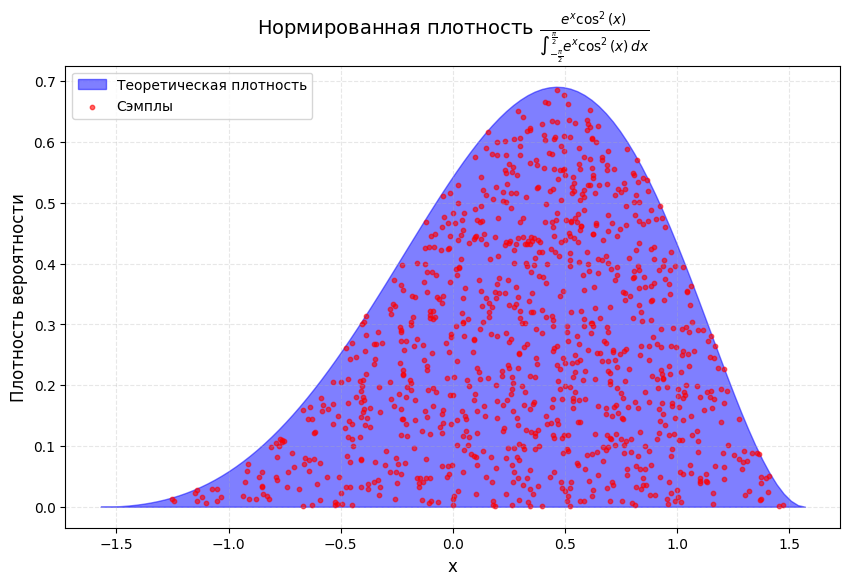

In [ ]:
import scipy.integrate as integrate

def den(x, norm):
    return np.exp(x) * np.cos(x) ** 2 / norm * ((x >= -np.pi/2) & (x <= np.pi/2))

num_samples = 1000

inter = integrate.quad(lambda x: np.exp(x) * np.cos(x) ** 2, -np.pi/2, np.pi/2)[0]

x_max = np.arctan(1/2)
max_value = np.exp(x_max) * np.cos(x_max) ** 2 / inter

samples_x, samples_y = [], []

while len(samples_x) < num_samples:
    s = np.random.uniform(-np.pi/2, np.pi/2)
    d = np.random.uniform(0, max_value)

    if (d < den(s, inter)):
        samples_x.append(s)
        samples_y.append(d)

x = np.linspace(-np.pi/2, np.pi/2, 100)
density = np.exp(x) * np.cos(x) ** 2 / inter

plt.figure(figsize=(10, 6))
plt.fill_between(x, 0, density, color='blue', alpha=0.5, label='Теоретическая плотность')
plt.scatter(samples_x, samples_y, color='red', s=10, alpha=0.6, label='Сэмплы')
plt.ylabel('Плотность вероятности', fontsize=12)
plt.xlabel('x', fontsize=12)
plt.title(r'Нормированная плотность $\frac{e^x \cos^2(x)}{\int_{-\frac{\pi}{2}}^{\frac{\pi}{2}} e^x \cos^2(x) \,dx}$', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

## Coordinate transformation method

The accept-reject method may in some cases be inefficient and require too many sample points. An alternative is to try to find a coordinate transformation that converts a simple area (from which it is easy to sample, for example, a unit square) into the required area, but preserves the area ratio (why?).

### Problem 7



Model and depict a sample of 500 points uniformly distributed within a given triangle without using a selection method.

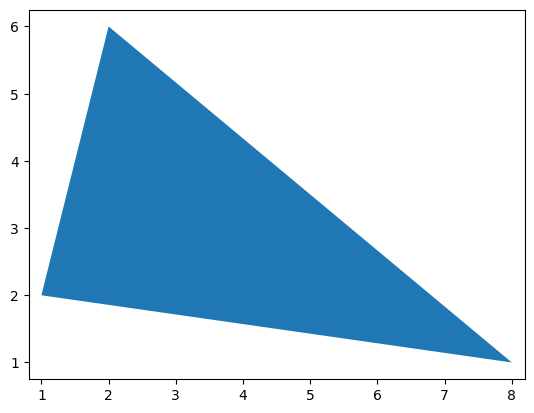

In [ ]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

fig = plt.figure()

polygon = Polygon(xy=np.array([[1, 2], [2, 6], [8, 1]]), closed=True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.axis('equal')
plt.show()

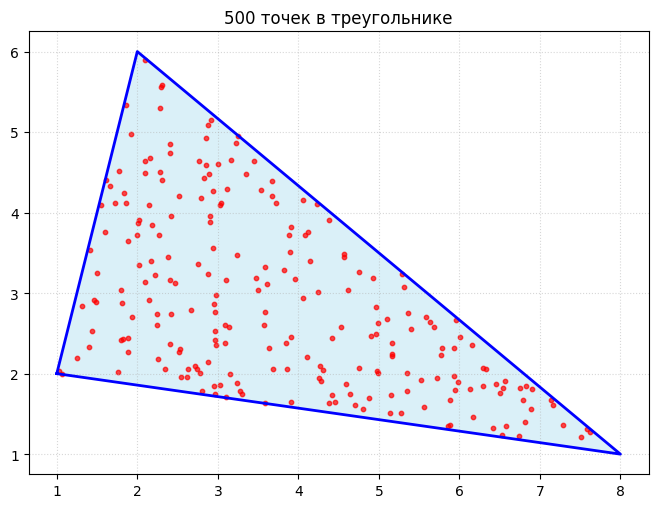

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

A = [1, 2]
B = [2, 6]
C = [8, 1]

n = 500
u = np.random.rand(n)
v = np.random.rand(n)
mask = u + v < 1
u = u[mask][:n]
v = v[mask][:n]

points = np.column_stack([
    (1 - u - v) * A[0] + u * B[0] + v * C[0],
    (1 - u - v) * A[1] + u * B[1] + v * C[1]
])

plt.figure(figsize=(8, 6))
plt.fill([A[0], B[0], C[0]], [A[1], B[1], C[1]], 'skyblue', alpha=0.3)
plt.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], 'b-', linewidth=2)
plt.scatter(points[:,0], points[:,1], color='red', s=10, alpha=0.7)
plt.gca().set_aspect('equal')
plt.title('500 точек в треугольнике', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()

### Problem 8
Model without using the selection method a sample of $500$ points uniformly distributed inside the unit circle. Picture the obtained points. Do they really fill the circle uniformly?

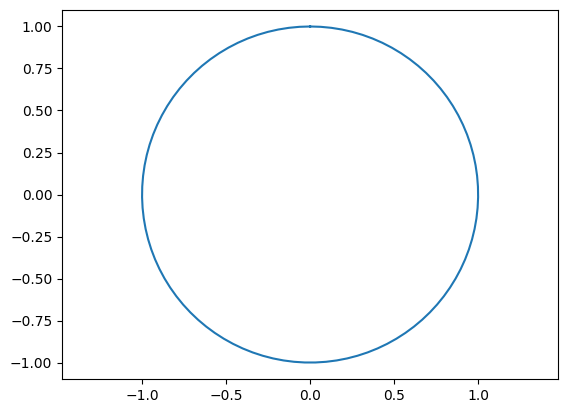

In [ ]:
fig = plt.figure()

t = np.linspace(0, 2*np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

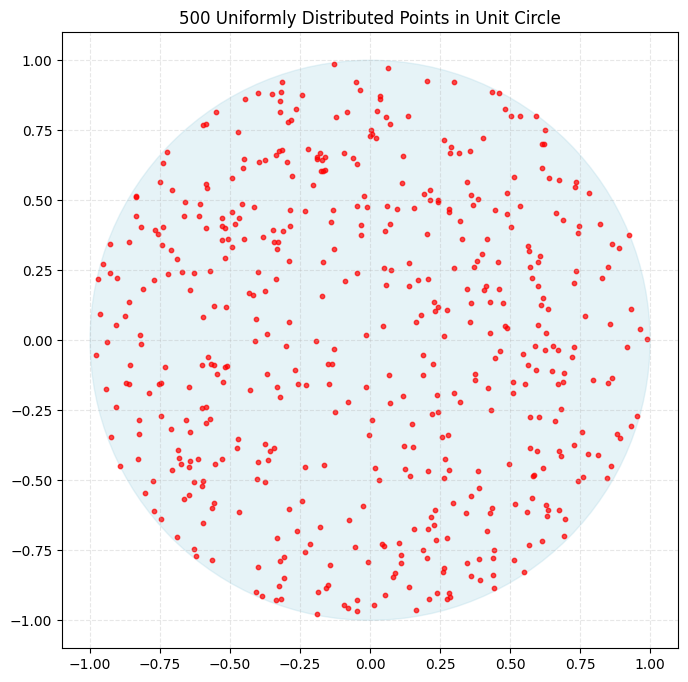

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n = 500

theta = np.random.uniform(0, 2*np.pi, n)

r = np.sqrt(np.random.uniform(0, 1, n))

x = r * np.cos(theta)
y = r * np.sin(theta)

plt.figure(figsize=(8, 8))
circle = plt.Circle((0, 0), 1, color='lightblue', alpha=0.3, fill=True)
plt.gca().add_patch(circle)
plt.scatter(x, y, color='red', s=10, alpha=0.7)
plt.gca().set_aspect('equal')
plt.title('500 Uniformly Distributed Points in Unit Circle', fontsize=12)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

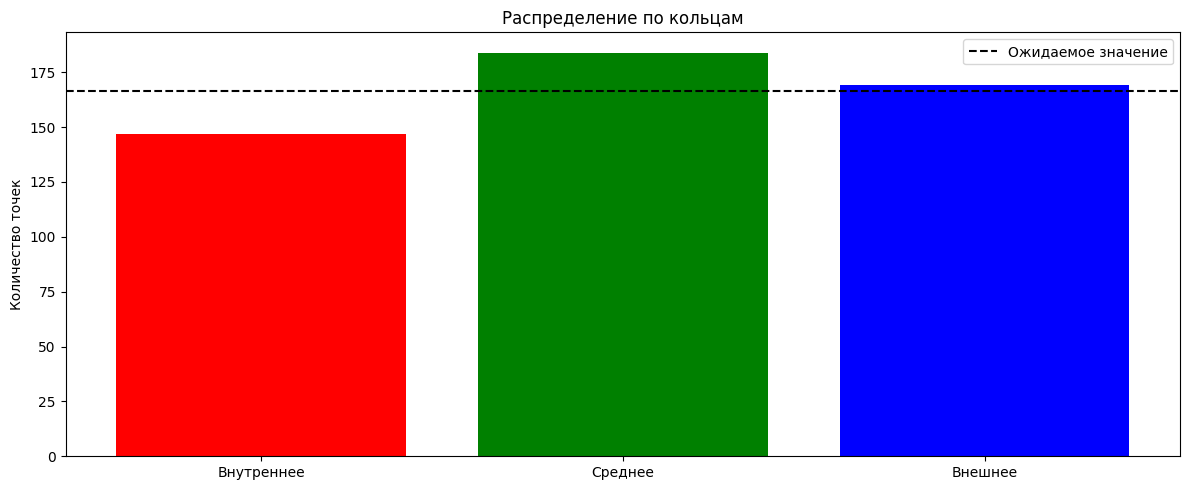

Теоретически в каждом кольце должно быть ~ 166 точек
Фактическое распределение:
Внутреннее кольцо: 147 точек (отклонение 3.9%)
Среднее кольцо: 184 точек (отклонение 3.5%)
Внешнее кольцо: 169 точек (отклонение 0.5%)


In [ ]:
rings = [
    (0, np.sqrt(1/3)),        # Внутреннее кольцо
    (np.sqrt(1/3), np.sqrt(2/3)),  # Среднее кольцо
    (np.sqrt(2/3), 1)         # Внешнее кольцо
]

# Считаем точки в каждом кольце
counts = []
for r_min, r_max in rings:
    mask = (r >= r_min) & (r < r_max)
    counts.append(np.sum(mask))

plt.figure(figsize=(12, 5))

plt.plot(1, 1, 1)
ring_names = ['Внутреннее', 'Среднее', 'Внешнее']
plt.bar(ring_names, counts, color=['red', 'green', 'blue'])
plt.axhline(n/3, color='black', linestyle='--', label='Ожидаемое значение')
plt.title('Распределение по кольцам')
plt.ylabel('Количество точек')
plt.legend()

plt.tight_layout()
plt.show()

print("Теоретически в каждом кольце должно быть ~", n//3, "точек")
print("Фактическое распределение:")
for name, count in zip(ring_names, counts):
    deviation = abs(count - n/3)/n * 100
    print(f"{name} кольцо: {count} точек (отклонение {deviation:.1f}%)")

# Random normal generator

### Problem 9
Prove (orally) that the following algorithm (**Box-Muller algorithm**, https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) generates a sample of independent $\mathcal{N}(0,1)$ random variables. Modify the method to exclude calls of trigonometric functions `np.sin` and `np.cos`. Using the modified method, simulate a sample size of $1000$ from a $2D$ Gaussian distribution with mean $\mu$ and covariance matrix $\Sigma$, where
$$\mu = \begin{pmatrix} 4 \\ 7 \end{pmatrix}^T, \quad \Sigma = \begin{pmatrix} 20 & -4 \\ -4 & 40 \end{pmatrix}.$$
Construct a 2D histogram of the resulting distribution. Compare the sample mean and covariance matrix with the exact values.

In [ ]:
import seaborn as sns

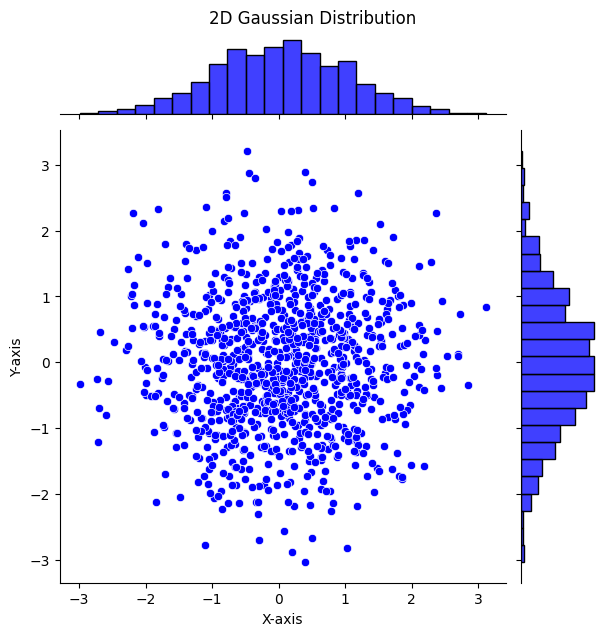

In [ ]:
n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)


joint_plot = sns.jointplot(x=x, y=y, color="blue")
joint_plot.set_axis_labels('X-axis', 'Y-axis')
plt.suptitle('2D Gaussian Distribution', y=1.02)
plt.show()

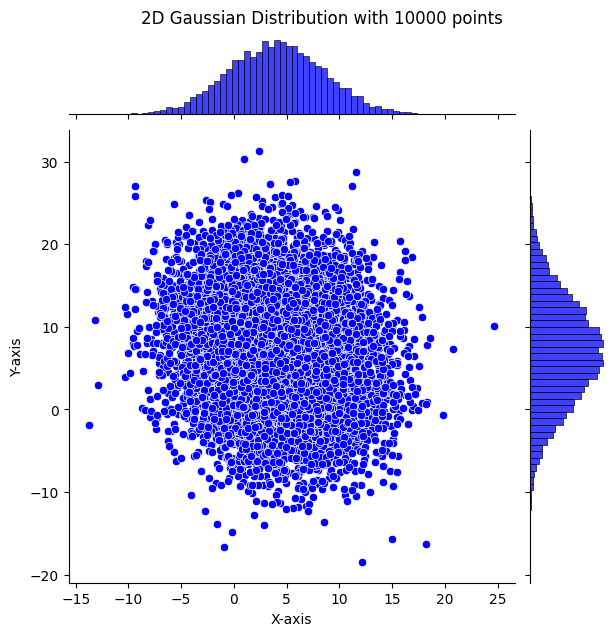

Sample Mean:
[4.01293549 6.9267292 ]
Sample Covariance Matrix:
[[20.63479925 -4.4275509 ]
 [-4.4275509  40.01040026]]
Exact Mean:
[4 7]
Exact Covariance Matrix:
[[20 -4]
 [-4 40]]


In [ ]:

import seaborn as sns

np.random.seed(42)

mu = np.array([4, 7])
Sigma = np.array([[20, -4], [-4, 40]])

L = np.linalg.cholesky(Sigma)

n = 10000
u1, u2 = np.random.rand(2, n)

r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
z0 = r * np.cos(theta)
z1 = r * np.sin(theta)

samples = np.dot(L, np.array([z0, z1])) + mu[:, np.newaxis]

x, y = samples

joint_plot = sns.jointplot(x=x, y=y, color="blue")
joint_plot.set_axis_labels('X-axis', 'Y-axis')
plt.suptitle('2D Gaussian Distribution with 10000 points', y=1.02)
plt.show()

sample_mean = np.mean(samples, axis=1)
sample_cov = np.cov(samples)

print(f"Sample Mean:\n{sample_mean}")
print(f"Sample Covariance Matrix:\n{sample_cov}")
print(f"Exact Mean:\n{mu}")
print(f"Exact Covariance Matrix:\n{Sigma}")


### Problem 10*

Implement a method of generating a random partition of an n-element set into subsets. Use it to estimate the expected number of subsets in a random partition of a set of 100 elements.

Hint 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Hint 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/

In [ ]:
# Your code here

# Basic distributions
- **Uniform distribution $\operatorname{U}[a, b]$**:
$$p(x) = \frac{1}{b-a}\cdot\mathbb{I}_{x\in[a, b]}$$

- **Exponential distribution $\operatorname{Exp}(\lambda)$**:
$$p(x) = \lambda e^{-\lambda x}\cdot\mathbb{I}_{x\geqslant0}$$

- **Normal distribution $\mathcal{N}(\mu, \sigma^2)$**:
$$p(x) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

- **Gamma distribution $\operatorname{Gamma}(\alpha, \lambda)$**:
$$p(x) = \frac{\lambda^\alpha}{\Gamma(\alpha)}x^{\alpha-1}e^{-\lambda x}\cdot\mathbb{I}_{x\geqslant0}$$

- **Beta distribution $\operatorname{Beta}(\alpha, \beta)$**:
$$p(x) = \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}x^{\alpha-1}(1-x)^{\beta-1}\cdot\mathbb{I}_{x\in[0, 1]}$$

- **$\chi^2$ distribution with $k$ degrees of freedom $\chi^2(k)$**:
$$p(x) = \frac{1}{2^{k/2}\Gamma(k/2)}x^{k/2-1}e^{-x/2}\cdot\mathbb{I}_{x\geqslant0}$$



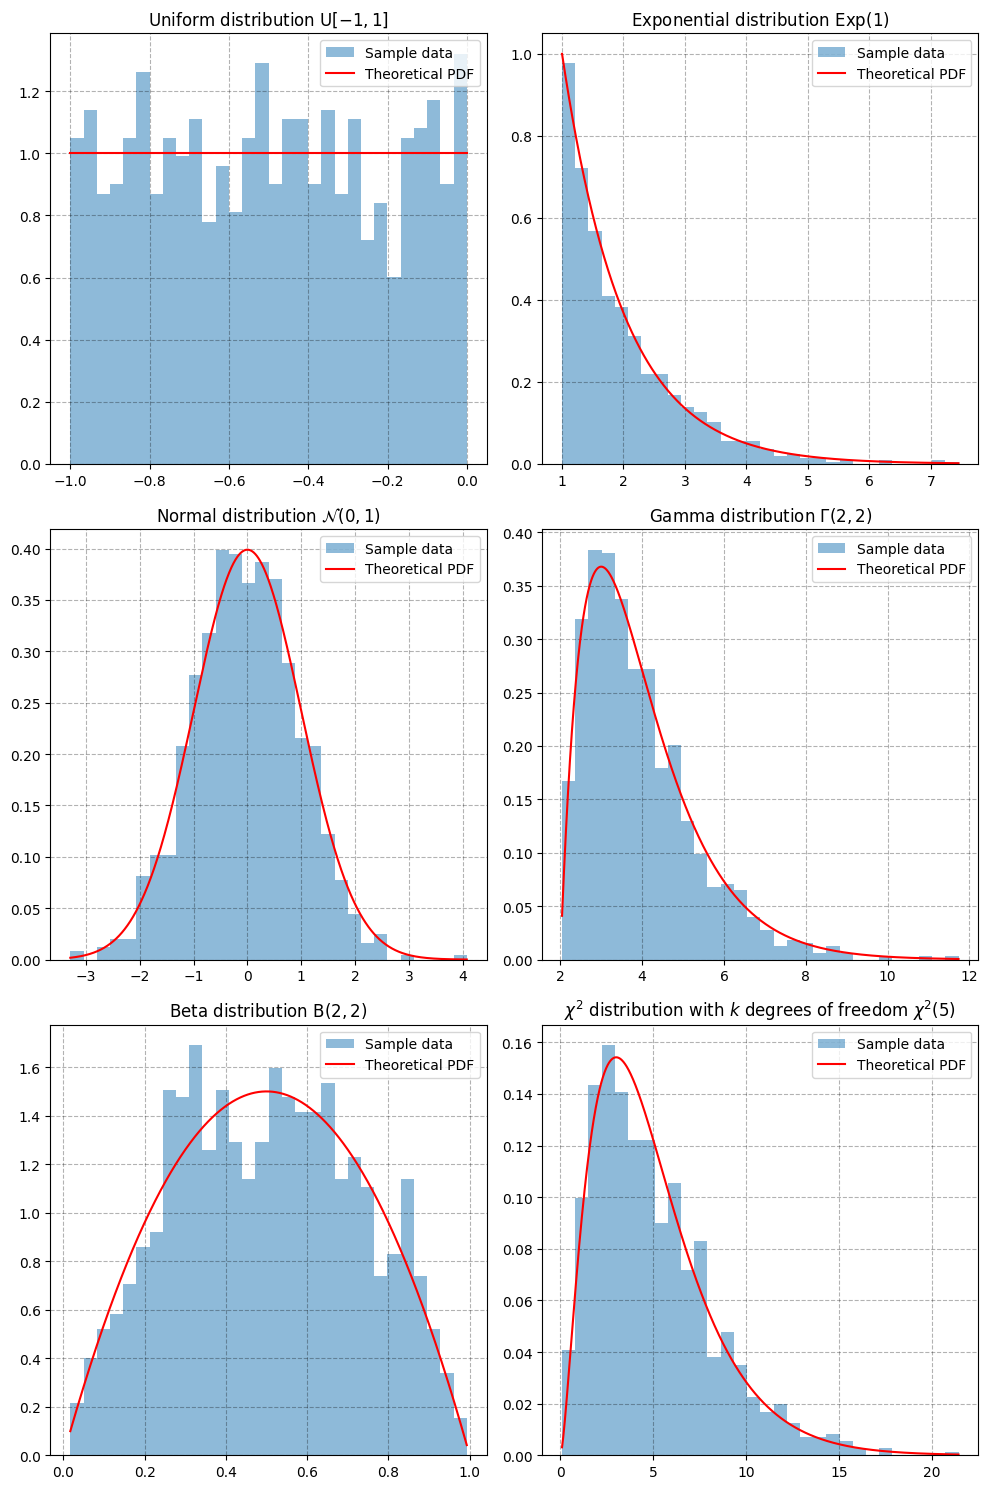

In [ ]:
# Define distributions and their parameters
distributions = [
    ("Uniform distribution $\\operatorname{U}[-1, 1]$", stats.uniform, (-1, 1)),
    ("Exponential distribution $\\operatorname{Exp}(1)$", stats.expon, (1,)),
    ("Normal distribution $\\mathcal{N}(0, 1)$", stats.norm, (0, 1)),
    ("Gamma distribution $\\Gamma(2, 2)$", stats.gamma, (2, 2)),
    ("Beta distribution $\\operatorname{B}(2, 2)$", stats.beta, (2, 2)),
    ("$\\chi^2$ distribution with $k$ degrees of freedom $\\chi^2(5)$", stats.chi2, (5,))
]

# Setup the figure and axes for a 2x3 subplot
fig, axs = plt.subplots(3, 2, figsize=(10, 15))  # Adjust figsize according to your needs
axs = axs.flatten()  # Flatten the array to easily iterate over it

for ax, (name, dist, params) in zip(axs, distributions):
    # Generate sample data
    data = dist.rvs(*params, size=1000)
    # Generate points for PDF
    x = np.linspace(min(data), max(data), 1000)
    pdf = dist.pdf(x, *params)

    # Plot histogram of sample data
    ax.hist(data, bins=30, density=True, alpha=0.5, label='Sample data')
    # Plot theoretical PDF
    ax.plot(x, pdf, 'r-', label='Theoretical PDF')
    ax.set_title(name)
    ax.legend()
    ax.grid(linestyle='--', color='black', alpha=0.3)

plt.tight_layout()  # Adjust subplots to fit in the figure area
plt.show()
